<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/notebook/03_tmle_ps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install causalml
!pip install zepid
!pip install rpy2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf 
from causalml import match
from zepid import (RiskDifference, RiskRatio, OddsRatio, NNT,
                   IncidenceRateRatio, IncidenceRateDifference)
from zepid.superlearner import GLMSL, StepwiseSL, SuperLearner
from zepid.causal.doublyrobust import TMLE, SingleCrossfitAIPTW, SingleCrossfitTMLE

import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter 
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import sys
import requests 
import io
import os
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
%load_ext rpy2.ipython

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing cohort_table

In [9]:
path = "/content/gdrive/MyDrive/midodrine"
fnames = os.listdir(path)
print(fnames)

['features_complete.csv', 'table_cohort.csv']


In [10]:
cohort_table = pd.read_csv(os.path.join(path, fnames[1]))
cohort_table

,stay_id,hadm_id,subject_id,age,Gender,ethnicity,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
0,36014877,27162817,11861017,87,0,WHITE,1,1.595745,0,1,...,17.600000,36.416667,100.000000,247.375000,1.0,1.0,1,0,0,15
1,32272859,25963696,11259141,60,1,WHITE,1,1.633333,0,7,...,17.333333,36.898333,97.259259,120.200000,1.0,1.0,1,0,0,18
2,34023828,21782431,18010960,59,0,UNKNOWN,1,1.589041,0,1,...,15.392857,36.786667,96.629630,98.000000,1.0,1.0,1,0,0,15
3,37798199,29764966,10926537,42,1,BLACK/AFRICAN AMERICAN,1,1.568627,0,7,...,17.240000,37.142857,99.791667,95.000000,1.0,1.0,1,0,0,17
4,32309766,29272306,15703353,59,1,WHITE,1,1.517241,0,6,...,21.740741,37.372000,98.178571,136.800000,1.0,1.0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35295,39955170,24679700,12799579,55,1,WHITE,0,1.464286,1,7,...,24.148148,37.325000,94.115385,148.333333,0.0,1.0,1,0,0,19
35296,39977793,20968809,13886051,66,1,WHITE,0,1.407407,1,3,...,14.400000,36.646364,97.205882,96.333333,0.0,1.0,1,1,1,19
35297,39980385,21253505,11392990,73,0,WHITE,0,1.592593,1,5,...,19.605263,36.835000,93.605263,203.200000,0.0,1.0,1,1,0,6
35298,39985296,29295929,19632565,59,1,WHITE,0,1.782609,1,2,...,25.692308,36.603333,96.296296,173.400000,0.0,1.0,1,1,1,15


In [ ]:
cohort_table.columns

Index(['stay_id', 'hadm_id', 'subject_id', 'age', 'Gender', 'ethnicity',
       'midodrine', 'avg_doses_per_24_hrs', 'MICU', 'adm_weekday', 'weight',
       'sapsii', 'charlson_index', 'CPD_or_COPD_rate', 'Maligancy_rate',
       'mild_liver_rate', 'severe_liver_rate', 'Renal_rate', 'CAD_rate',
       'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium', 'potassium',
       'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate', 'ph', 'po2',
       'pco2', 'bnp', 'troponin', 'creatinine_kinase', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

In [ ]:
cohort_table.describe()

,stay_id,hadm_id,subject_id,age,Gender,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,weight,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
count,3.530000e+04,3.530000e+04,3.530000e+04,35300.000000,35300.000000,35300.000000,35184.000000,35300.000000,35300.000000,34620.000000,...,35235.000000,34986.000000,35214.000000,34326.000000,35113.000000,25512.0,35300.0,35300.000000,35300.000000,35300.000000
mean,3.498390e+07,2.497613e+07,1.499966e+07,62.705694,0.469830,0.022946,1.622051,0.534334,3.992663,80.654058,...,19.282602,36.878330,96.686357,260.224735,0.392647,1.0,1.0,0.172550,0.111841,12.855581
std,2.892380e+06,2.889905e+06,2.887420e+06,18.424232,0.499096,0.149734,0.357446,0.498827,1.995172,26.148795,...,3.934879,0.543675,2.634797,7141.871173,0.488346,0.0,0.0,0.377863,0.315176,7.540701
min,3.000015e+07,2.000035e+07,1.000003e+07,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,6.000000,30.400000,26.600000,34.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000
25%,3.245169e+07,2.247389e+07,1.249361e+07,51.000000,0.000000,0.000000,1.400000,0.000000,2.000000,64.700000,...,16.500000,36.626278,95.542857,107.333333,0.000000,1.0,1.0,0.000000,0.000000,5.000000
50%,3.499433e+07,2.494200e+07,1.501041e+07,64.000000,0.000000,0.000000,1.575000,1.000000,4.000000,77.100000,...,18.653846,36.853333,96.941176,129.000000,0.000000,1.0,1.0,0.000000,0.000000,15.000000
75%,3.748920e+07,2.747473e+07,1.750540e+07,77.000000,1.000000,0.000000,1.794872,1.000000,6.000000,92.300000,...,21.454545,37.135714,98.315789,159.750000,1.000000,1.0,1.0,0.000000,0.000000,19.000000
max,3.999938e+07,2.999962e+07,1.999999e+07,102.000000,1.000000,1.000000,9.250000,1.000000,7.000000,1120.000000,...,48.000000,40.104118,100.000000,999999.000000,1.000000,1.0,1.0,1.000000,1.000000,23.000000


In [ ]:
cohort_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35300 entries, 0 to 35299
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_id               35300 non-null  int64  
 1   hadm_id               35300 non-null  int64  
 2   subject_id            35300 non-null  int64  
 3   age                   35300 non-null  int64  
 4   Gender                35300 non-null  int64  
 5   ethnicity             35300 non-null  object 
 6   midodrine             35300 non-null  int64  
 7   avg_doses_per_24_hrs  35184 non-null  float64
 8   MICU                  35300 non-null  int64  
 9   adm_weekday           35300 non-null  int64  
 10  weight                34620 non-null  float64
 11  sapsii                26683 non-null  float64
 12  charlson_index        35300 non-null  float64
 13  CPD_or_COPD_rate      35300 non-null  float64
 14  Maligancy_rate        35300 non-null  float64
 15  mild_liver_rate    

In [ ]:
cohort_table = cohort_table.drop(columns=['ethnicity','hadm_id','subject_id'])

In [ ]:
mido_data = cohort_table.loc[cohort_table['midodrine'] == 1]
nomido_data = cohort_table.loc[cohort_table['midodrine'] == 0]

# TMLE

## Simple TMLE

In [ ]:
import statsmodels.api as sm

In [ ]:
# SuperLearner setup
labels = ["LogR", "Step.int", "RandFor"]
candidates = [GLMSL(sm.families.family.Binomial()), 
              StepwiseSL(sm.families.family.Binomial(), selection="forward", order_interaction=0),
              XGBClassifier()]

In [ ]:
tml =  TMLE(cohort_table, exposure='midodrine', outcome='mort_28_day')

In [ ]:
cohort_table.columns

Index(['stay_id', 'age', 'Gender', 'midodrine', 'avg_doses_per_24_hrs', 'MICU',
       'adm_weekday', 'weight', 'sapsii', 'charlson_index', 'CPD_or_COPD_rate',
       'Maligancy_rate', 'mild_liver_rate', 'severe_liver_rate', 'Renal_rate',
       'CAD_rate', 'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium',
       'potassium', 'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate',
       'ph', 'po2', 'pco2', 'bnp', 'troponin', 'creatinine_kinase',
       'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

In [ ]:
tml.exposure_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )  

Propensity Score Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:              midodrine   No. Observations:                11644
Model:                            GLM   Df Residuals:                    11608
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1555.8
Date:                Wed, 22 Jun 2022   Deviance:                       3111.7
Time:                        06:31:57   Pearson chi2:                 1.30e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept      

In [ ]:
tml.outcome_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:            mort_28_day   No. Observations:                11644
Model:                            GLM   Df Residuals:                    11608
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4402.6
Date:                Wed, 22 Jun 2022   Deviance:                       8805.2
Time:                        06:32:28   Pearson chi2:                 1.10e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.

In [ ]:
tml.fit() 

In [ ]:
tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        midodrine       No. Observations:     11644               
Outcome:          mort_28_day     No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     0.012
95.0% two-sided CI: (-0.033 , 0.057)
----------------------------------------------------------------------
Risk Ratio:          1.067
95.0% two-sided CI: (0.845 , 1.346)
----------------------------------------------------------------------
Odds Ratio:          1.082
95.0% two-sided CI: (0.811 , 1.444)


	Exposure Model Diagnostics
                   Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.957
Standard Deviation:     7.3
Minimum weight:         1.01
Maximum weight:         100.0

                  Standardized Mean Differences
                          smd_w     smd_u
labels                                   
age               -1.350501e-02 -0.059827
MICU              -8.628047e-02  0.169140
Gender            -7.870642e-02 -0.073722
adm_weekday        4.080462e-02 -0.031428
weight            -9.623617e-02  0.163847
sapsii             1.243305e-01  0.515211
charlson_index     1.960068e-02  0.368102
CPD_or_COPD_rate  -1.969641e-02 -0.082643
Maligancy_rate    -1.740774e-02 -0.058935
mild_liver_rate   -7.318970e-02  0.874871
severe_liver_rate -1.7045

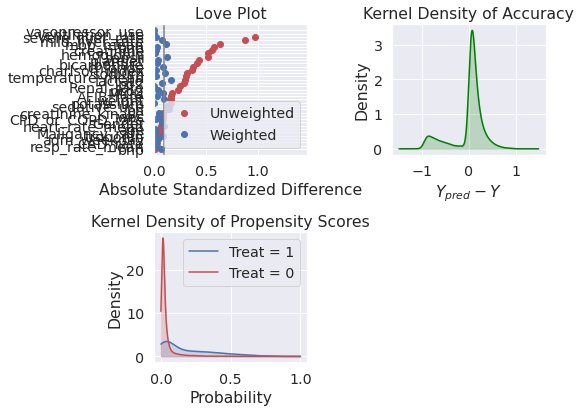

In [ ]:
tml.run_diagnostics()

## Superlearner TMLE 

In [ ]:
%%R
install.packages("tmle")
install.packages("xgboost")
install.packages("earth")

In [18]:
%%R
library(tidyverse)
library(tmle)
library(xgboost)
library(earth)

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: plotmo

R[write to console]: Loading required package: plotrix

R[write to console]: Loading required package: TeachingDemos



In [8]:
%%R
cohort_data <- read.csv("/content/gdrive/MyDrive/midodrine/table_cohort.csv")

In [12]:
%%R
class(cohort_data)

[1] "data.frame"


In [29]:
%%R
as_tibble(cohort_data)

# A tibble: 35,300 × 50
    stay_id hadm_id subject_id   age Gender ethnicity midodrine avg_doses_per_2…
      <int>   <int>      <int> <int>  <int> <chr>         <int>            <dbl>
 1 36014877  2.72e7   11861017    87      0 WHITE             1             1.60
 2 32272859  2.60e7   11259141    60      1 WHITE             1             1.63
 3 34023828  2.18e7   18010960    59      0 UNKNOWN           1             1.59
 4 37798199  2.98e7   10926537    42      1 BLACK/AF…         1             1.57
 5 32309766  2.93e7   15703353    59      1 WHITE             1             1.52
 6 32470068  2.99e7   12682108    32      1 WHITE             1             1.67
 7 39913468  2.56e7   14695267    26      0 UNKNOWN           1             1.96
 8 36158255  2.69e7   11544355    29      0 UNKNOWN           1             1.69
 9 39406131  2.71e7   16583373    51      0 WHITE             1             1.64
10 38515563  2.42e7   11896370    62      1 WHITE             1             1.37
# … 

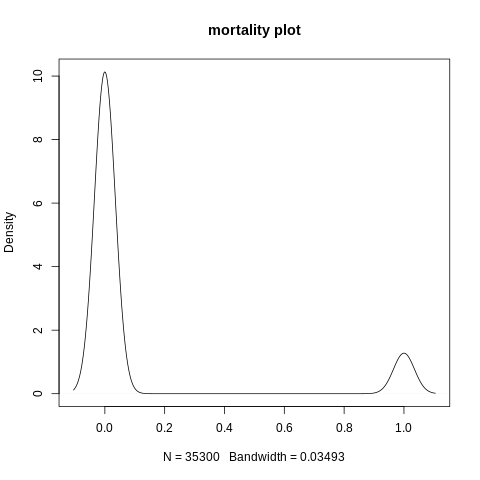

In [ ]:
%%R
plot(density(cohort_data$mort_28_day), main = "mortality plot") #should come out as bionomial

In [9]:
%%R
features = subset(cohort_data,select=-c(stay_id,hadm_id,subject_id,ethnicity,midodrine,avg_doses_per_24_hrs,mortality,mort_28_day,vasopressor_use))

In [10]:
%%R
features_complete <- read.csv("/content/gdrive/MyDrive/midodrine/features_complete.csv") #Imputed feature table
features_complete = subset(features_complete,select=-c(X))

In [20]:
%%R
str(features_complete)

'data.frame':	35300 obs. of  41 variables:
 $ age              : int  87 60 59 42 59 32 26 29 51 62 ...
 $ Gender           : int  0 1 0 1 1 1 0 0 0 1 ...
 $ MICU             : int  0 0 0 0 0 0 0 0 1 0 ...
 $ adm_weekday      : int  1 7 1 7 6 3 2 7 1 5 ...
 $ weight           : num  70 81.6 90 73 72.7 86.3 81 66.8 62 111 ...
 $ sapsii           : int  42 34 15 30 20 18 38 24 31 23 ...
 $ charlson_index   : num  8.83 3.33 3 2 3 ...
 $ CPD_or_COPD_rate : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Maligancy_rate   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mild_liver_rate  : int  0 0 0 0 0 0 0 0 1 0 ...
 $ severe_liver_rate: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Renal_rate       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ CAD_rate         : int  1 0 0 0 0 0 0 0 0 0 ...
 $ AFIB_rate        : int  0 1 0 0 0 0 0 0 1 0 ...
 $ hemoglobin       : num  10.4 11.2 13.2 12.4 8 ...
 $ platelet         : num  273 238 157 195 223 ...
 $ wbc              : num  11.7 10.6 11.5 12.1 10.2 ...
 $ sodium           : num  136 135 142 140 136 .

In [11]:
%%R
summary(features_complete)

      age             Gender            MICU         adm_weekday   
 Min.   : 18.00   Min.   :0.0000   Min.   :0.0000   Min.   :1.000  
 1st Qu.: 51.00   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:2.000  
 Median : 64.00   Median :0.0000   Median :1.0000   Median :4.000  
 Mean   : 62.71   Mean   :0.4698   Mean   :0.5343   Mean   :3.993  
 3rd Qu.: 77.00   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:6.000  
 Max.   :102.00   Max.   :1.0000   Max.   :1.0000   Max.   :7.000  
                                                                   
     weight           sapsii       charlson_index   CPD_or_COPD_rate
 Min.   :   1.0   Min.   :  0.00   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:  64.7   1st Qu.: 24.00   1st Qu.: 3.000   1st Qu.:0.0000  
 Median :  77.1   Median : 32.00   Median : 5.000   Median :0.0000  
 Mean   :  80.7   Mean   : 34.06   Mean   : 5.026   Mean   :0.2337  
 3rd Qu.:  92.4   3rd Qu.: 42.00   3rd Qu.: 7.000   3rd Qu.:0.0000  
 Max.   :1120.0   Max.   :114.00   Max.   

In [12]:
%%R
# using colMeans()
mean_val <- colMeans(features_complete,na.rm = TRUE)
  
# replacing NA with mean value of each column
for(i in colnames(features_complete))
  features_complete[,i][is.na(features_complete[,i])] <- mean_val[i]

In [13]:
%%R
summary(features_complete)

      age             Gender            MICU         adm_weekday   
 Min.   : 18.00   Min.   :0.0000   Min.   :0.0000   Min.   :1.000  
 1st Qu.: 51.00   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:2.000  
 Median : 64.00   Median :0.0000   Median :1.0000   Median :4.000  
 Mean   : 62.71   Mean   :0.4698   Mean   :0.5343   Mean   :3.993  
 3rd Qu.: 77.00   3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:6.000  
 Max.   :102.00   Max.   :1.0000   Max.   :1.0000   Max.   :7.000  
     weight           sapsii       charlson_index   CPD_or_COPD_rate
 Min.   :   1.0   Min.   :  0.00   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:  64.7   1st Qu.: 24.00   1st Qu.: 3.000   1st Qu.:0.0000  
 Median :  77.1   Median : 32.00   Median : 5.000   Median :0.0000  
 Mean   :  80.7   Mean   : 34.06   Mean   : 5.026   Mean   :0.2337  
 3rd Qu.:  92.4   3rd Qu.: 42.00   3rd Qu.: 7.000   3rd Qu.:0.0000  
 Max.   :1120.0   Max.   :114.00   Max.   :19.000   Max.   :1.0000  
 Maligancy_rate   mild_liver_rate  severe

In [21]:
%%R 
set.seed(20220614)
SL.library = c("SL.glm", "SL.glmnet", "SL.xgboost") # Faster library
g.SL.library <- c("SL.glm", "SL.glmnet", "SL.stepAIC", "SL.glm.interaction", "SL.mean", "SL.earth", "SL.gam", "SL.xgboost")
Q.SL.library <- c("SL.glm", "SL.glmnet", "SL.stepAIC", "SL.rpartPrune", "SL.mean", "SL.xgboost")

In [26]:
%%R
colnames(features_complete)

 [1] "age"               "Gender"            "MICU"             
 [4] "adm_weekday"       "weight"            "sapsii"           
 [7] "charlson_index"    "CPD_or_COPD_rate"  "Maligancy_rate"   
[10] "mild_liver_rate"   "severe_liver_rate" "Renal_rate"       
[13] "CAD_rate"          "AFIB_rate"         "hemoglobin"       
[16] "platelet"          "wbc"               "sodium"           
[19] "potassium"         "bicarbonate"       "chloride"         
[22] "bun"               "creatinine"        "lactate"          
[25] "ph"                "po2"               "pco2"             
[28] "bnp"               "troponin"          "creatinine_kinase"
[31] "heart_rate_mean"   "sbp_mean"          "dbp_mean"         
[34] "mbp_mean"          "resp_rate_mean"    "temperature_mean" 
[37] "spo2_mean"         "glucose_mean"      "sedative_use"     
[40] "ventilation_use"   "admit_hour"       


In [22]:
%%R
tmle.fit <- tmle::tmle(Y = cohort_data$mort_28_day, 
                   A = cohort_data$midodrine, 
                   W = features_complete,
                   family = "binomial",
                   V = 3,
                   Q.SL.library = Q.SL.library, 
                   g.SL.library = g.SL.library)

In [24]:
%%R
tmle.fit

 Additive Effect
   Parameter Estimate:  0.020201
   Estimated Variance:  6.2452e-06
              p-value:  6.2992e-16
    95% Conf Interval: (0.015303, 0.025099) 

 Additive Effect among the Treated
   Parameter Estimate:  0.044206
   Estimated Variance:  0.00024874
              p-value:  0.0050642
    95% Conf Interval: (0.013294, 0.075119) 

 Additive Effect among the Controls
   Parameter Estimate:  -0.073219
   Estimated Variance:  5.6632e-06
              p-value:  <2e-16
    95% Conf Interval: (-0.077883, -0.068554) 

 Relative Risk
   Parameter Estimate:  1.1821
              p-value:  2.0489e-16
    95% Conf Interval: (1.1359, 1.2303) 

              log(RR):  0.16732
    variance(log(RR)):  0.00041441 

 Odds Ratio
   Parameter Estimate:  1.2096
              p-value:  2.3183e-16
    95% Conf Interval: (1.1559, 1.2659) 

              log(OR):  0.1903
    variance(log(OR)):  0.00053802 


In [25]:
%%R
summary(tmle.fit)

 Initial estimation of Q
	 Procedure: cv-SuperLearner, ensemble
	 Model:
		 Y ~  SL.glm_All + SL.glmnet_All + SL.stepAIC_All + SL.rpartPrune_All + SL.mean_All + SL.xgboost_All

	 Coefficients: 
	      SL.glm_All    0.3197596 
	   SL.glmnet_All    0 
	  SL.stepAIC_All    0 
	 SL.rpartPrune_All    0.002885355 
	     SL.mean_All    0.07231428 
	  SL.xgboost_All    0.6050407 

	 Cross-validated pseudo R squared :  0.2764 

 Estimation of g (treatment mechanism)
	 Procedure: SuperLearner, ensemble	 Empirical AUC = 0.9877 

	 Model:
		 A ~  SL.glm_All + SL.glmnet_All + SL.stepAIC_All + SL.glm.interaction_All + SL.mean_All + SL.earth_All + SL.gam_All + SL.xgboost_All 

	 Coefficients: 
	      SL.glm_All    0 
	   SL.glmnet_All    0 
	  SL.stepAIC_All    0 
	 SL.glm.interaction_All    0.03884595 
	     SL.mean_All    0.04402138 
	    SL.earth_All    0.2330481 
	      SL.gam_All    0.4837776 
	  SL.xgboost_All    0.2003069 

 Estimation of g.Z (intermediate variable assignment mechanism)
	 Proc

In [30]:
%%R
tmle.fit$estimates$ATE

$psi
[1] 0.02020073

$var.psi
[1] 6.245215e-06

$CI
[1] 0.01530261 0.02509886

$pvalue
[1] 6.299186e-16



In [29]:
%%R
tmle.fit$estimates$ATT

$psi
[1] 0.04420634

$converged
[1] TRUE

$var.psi
[1] 0.0002487409

$CI
[1] 0.01329415 0.07511852

$pvalue
[1] 0.005064199



In [36]:
%%R
propensity_score <- tmle.fit$g$g1W

In [37]:
%%R
write.csv(propensity_score, "ps.csv")